# Minimal regression model to capture seasonal dependencies

In [1]:
import pandas as pd
import numpy as np

import polars as pl
import datetime

import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Lasso


## Notebook Setup

### Environment Setup

In [2]:
__context__ = 'local'

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    iter_test = env.iter_test()


elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    import enefit
    env = enefit.make_env()
    iter_test = env.iter_test()



## Train the model

### Import and process training data

In [3]:
def format_dfs(test, client):
    """ dataframe formatting for training and online use """
    # test formatting
    test.dropna(axis='index', inplace=True)
    test = test.rename(columns={'datetime':'prediction_datetime'})
    test['prediction_datetime'] = pd.to_datetime(test['prediction_datetime'])
    test = pl.from_pandas( test)
    test = test.with_columns(
                (pl.col('prediction_datetime').dt.date() +
                    datetime.timedelta(days=-2) ).alias('date_when_predicting')
              )

    # client formatting
    client['date'] = pd.to_datetime(client['date']).dt.date
    client = pl.from_pandas(client)
    
    #return (test, revealed_targets, client, 
    #        weatherHistorical, weatherForecast,
    #        electricityPrices, gasPrices, sample_prediction)

    return test, client


#### Date Note:
We want to predict targets using the data from two days previous

In [4]:
train = pd.read_csv(trainDataLocation+'train.csv')
clients = pd.read_csv(trainDataLocation+'client.csv')


train, clients = format_dfs(train, clients)

### Making features

In [5]:
# make deterministic time dependent features
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def make_date_process(train):
    dates = pd.date_range( train['prediction_datetime'].dt.date().min(), train['prediction_datetime'].dt.date().max() )
    fourier = CalendarFourier(freq="A", order=6) 
    date_process = DeterministicProcess(dates,
                           constant=True,
                           order=0,
                           seasonal=True,
                           period=7,
                           additional_terms=[fourier],
                           drop=True
                          )
    return date_process


# make possible unit identifiers 
from itertools import product

def possible_identifiers_assembled(train):
    """ create a categorical type with all combinations of county, is_buisness, and product_type """
    unique_counties = train['county'].unique()
    unique_is_business = train['is_business'].unique()
    unique_product_type = train['product_type'].unique()
    
    def string_representation(signature):
        (county, is_business, product_type) = signature
        return str(county) + '-' + str(is_business) + '-' + str(product_type)
    
    possible_ids = map( string_representation, product(unique_counties, unique_is_business, unique_product_type) )
    
    return pd.CategoricalDtype(possible_ids)

def possible_identifiers(train):
    return pd.CategoricalDtype( train['prediction_unit_id'].unique())


In [6]:
# make target features

def make_targets(train):
    """ Preprocess the training features, using log(x+1) transformed targets """
    train = train.drop(['county', 'is_business', 'product_type', 'prediction_datetime',
                        'data_block_id', 'prediction_unit_id', 'date_when_predicting'])
    return train.with_columns( np.log1p(pl.col('target')) )

def raw_targets(predictions):
    """ Undo the preprocessing to make the raw features """
    predictions['target'] = np.expm1(predictions['target'] )
    return predictions


<Axes: ylabel='Frequency'>

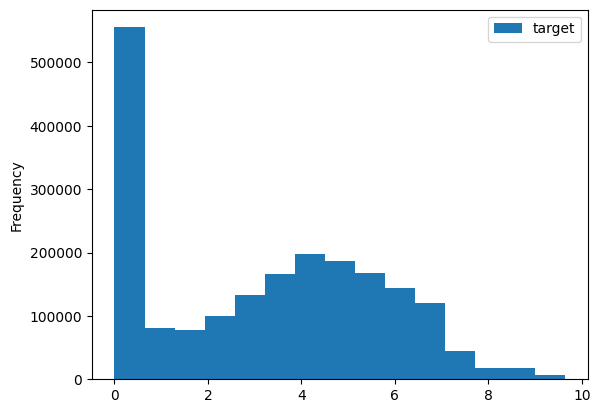

In [7]:
targets = make_targets(train)
targets.to_pandas().plot(y='target', kind='hist', bins=15)

This target distribution, while not entirely normal is much closer than before

In [8]:
def make_regression_features(train, clients, date_process, possible_ids):
    """ input features for the regression"""
    features = train.join(clients, 
                          left_on=['county', 'is_business', 'product_type', 'date_when_predicting'],
                          right_on=['county', 'is_business', 'product_type', 'date'],
                          how='inner' )

    # add date and time features
    features = features.with_columns( 
                                        pl.col('prediction_datetime').dt.date().alias('prediction_date'),
                                        pl.col('prediction_datetime').dt.time().alias('prediction_time')
                                        )

    # features from the date process
    date_features = date_process.range(
                                       features['prediction_date'].min(),
                                       features['prediction_date'].max()
                                      ).reset_index()
    date_features = pl.from_pandas( date_features ).with_columns(pl.col('index').dt.date())
    features = features.join(date_features, left_on=['prediction_date'], right_on=['index'], how='left')

    # time features:
    # to add: local holidays
    features = features.to_dummies('prediction_time', drop_first=True) # alternative idea: use Fourier time features for regularization
    
    

    # Other covariates
    features = features.with_columns( np.log1p( pl.col('installed_capacity')))

    unit_ids = pl.from_pandas(pd.get_dummies(
                                  pd.DataFrame(features['prediction_unit_id'], dtype=possible_ids, columns=['prediction_id_signature']),
                                  dtype=int,
                                  drop_first=True
                            ))
    #features = features.to_dummies('prediction_unit_id', drop_first=True)

    
    
    # some of these features should be included in the future
    columns_to_drop = ['target', 'data_block_id', 'data_block_id_right', 'prediction_date',
                       'prediction_datetime', 'date_when_predicting', 'prediction_unit_id',
                       'county', 'is_business', 'product_type', 'eic_count'
                      ]
    features = features.drop(columns_to_drop)
    
    return pl.concat([features, unit_ids], how='horizontal')


### Process training features

In [9]:
date_process = make_date_process(train)
possible_ids = possible_identifiers(train)

targets = make_targets(train)
features = make_regression_features(train, clients, date_process, possible_ids)

In [10]:
trainSet = targets.join(features, on='row_id', how='inner')
productionSet = trainSet.filter(pl.col('is_consumption') == 0).drop(['is_consumption', 'is_consumption_right']).to_pandas().set_index('row_id')
consumptionSet = trainSet.filter(pl.col('is_consumption') == 1).drop(['is_consumption', 'is_consumption_right']).to_pandas().set_index('row_id')

In [11]:
consumptionTargets = consumptionSet['target']
consumptionInputs = consumptionSet.drop(columns='target')

In [12]:
productionTargets = productionSet['target']
productionInputs = productionSet.drop(columns='target')

### Train the linear regression model

In [13]:
consumptionModel = LinearRegression()
productionModel = LinearRegression()

In [14]:
consumptionModel.fit(consumptionInputs, consumptionTargets)

LinearRegression()

In [15]:
consumptionModel.score(consumptionInputs, consumptionTargets)

0.8849048473857657

In [16]:
productionModel.fit(productionInputs, productionTargets)

LinearRegression()

In [17]:
productionModel.score(productionInputs, productionTargets)

0.7000043924580849

### Make predictions

In [18]:
for (test, revealed_targets, client, weatherHistorical, weatherForecast,
    electricityPrices, gasPrices, sample_prediction) in iter_test:

    test, client = format_dfs(test, client)
    features = make_regression_features(test, client, date_process, possible_ids)

    productionFeatures = features.filter(pl.col('is_consumption') == 0
                                        ).drop(['is_consumption', 'currently_scored']
                                              ).to_pandas().set_index('row_id')

    consumptionFeatures = features.filter(pl.col('is_consumption') == 1
                                         ).drop(['is_consumption', 'currently_scored']
                                               ).to_pandas().set_index('row_id')
    
    productionPredictions = pd.DataFrame({'row_id': productionFeatures.index,
                                          'target':productionModel.predict( productionFeatures)})
    consumptionPredictions = pd.DataFrame({'row_id': consumptionFeatures.index,
                                          'target':consumptionModel.predict( consumptionFeatures)})

    fullPredictions = raw_targets(pd.concat([productionPredictions, consumptionPredictions]))
    prediction = sample_prediction.merge(fullPredictions, on='row_id', how='left', suffixes=['_old', '']
                                        ).drop(columns='target_old').fillna(0.0)
    env.predict(prediction)


In [20]:
consumptionModel.coef_

array([ 7.55197828e-01, -3.42685543e-02, -4.70023382e-02, -4.88899835e-02,
       -4.78312410e-02, -3.63326157e-02,  2.79604253e-02,  5.76261561e-02,
        5.40204528e-04, -1.35803982e-01, -2.88043293e-01, -3.82944627e-01,
       -4.45290632e-01, -4.30191261e-01, -4.05080953e-01, -3.29901837e-01,
       -2.39222595e-01, -1.20309445e-01,  4.44545353e-03,  9.61319693e-02,
        1.44873704e-01,  1.48277339e-01,  1.08683216e-01,  3.93451775e-02,
       -5.32875093e+10,  4.79739916e-04, -1.45709411e-02, -1.56863074e-01,
       -1.98574301e-01, -2.08493631e-02,  1.06876631e-02,  4.89078107e-02,
        6.33761766e-01,  2.03113556e-02, -5.60760498e-04, -1.31263733e-02,
        4.08554077e-03, -3.09305191e-02, -1.43432617e-02, -1.24161243e-02,
       -1.21231079e-02, -1.11961365e-03, -2.93941498e-02, -4.86949325e-01,
        1.13724947e-01,  1.21756369e+00,  1.05924189e+00,  1.81348777e+00,
       -1.07659966e+00, -9.75327969e-01,  8.16710144e-02, -9.35875788e-01,
        1.43383554e+00, -

## Note taking: eliminating linear redundancies in the covariates

### good:
- capacity
- fourier components

### bad:
- prediction id - large or zero